# Gaus_Classifier
Gaussian classifier




**Author:** Lailin XU  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, May 12, 2021 at 10:31 AM.</small></i>

In [1]:
import os
from math import sqrt, pow, fabs, log, cos, sin, pi, atan, exp
from subprocess import call
import ROOT as R
R.gROOT.SetStyle("ATLAS")
R.gStyle.SetPalette(1)

Welcome to JupyROOT 6.22/07


Optionally one can use numpy to get the covariance matrix easily
import numpy as np 

Read training data
=====================

In [2]:
fname_tr = "class_data.root"
if not os.path.isfile(fname_tr):
    call(['curl', '-L', '-O', 'http://yliu.web.cern.ch/yliu/HLZ_logs/class_data.root'])
tfin_tr = R.TFile.Open(fname_tr, "READ")
tr_s = tfin_tr.Get("signal;1")
tr_b = tfin_tr.Get("background;1")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   172  100   172    0     0    107      0  0:00:01  0:00:01 --:--:--   107
100 28.5M  100 28.5M    0     0  2582k      0  0:00:11  0:00:11 --:--:-- 5475k


Split events into training and testing

In [3]:
ns = tr_s.GetEntries()
nb = tr_b.GetEntries()
print("Number of events: signal {0}, bkg {1}\n".format(ns, nb))

l_tr_s, l_tr_b = [], []
l_test_s, l_test_b = [], []

Number of events: signal 1000000, bkg 1000000



Do roration

In [4]:
doRotation = 1
ang = -atan(0.32)

def do_rotation(x, y, ang=pi/4.):
  
  yp = -sin(ang)*x + cos(ang)*y  
  xp = cos(ang)*x + sin(ang)*y  
  
  return (xp, yp)

Helper func to loop trees

In [5]:
def read_tr(tr):

  # Split the data into training and testing
  l_tr, l_test = [], []

  ns = tr.GetEntries()
  print("[read_tr] {0}, Number of events: {1}".format(tr.GetName(), ns))
  # loop the tree 
  for i in range(ns):
    tr.GetEntry(i)
    if i%(int(ns*0.1)) == 0:
      print(" Events processed: ", i)

    x1 = tr.X1
    x2 = tr.X2
    if doRotation:
      (x1, x2) = do_rotation(x1, x2, ang)
      
    # training data
    if i%1000 == 0:
      l_tr.append([x1, x2])
    else:
    # testing data
      l_test.append([x1, x2])

  return [l_tr, l_test]

Read signal events

In [6]:
[l_tr_s, l_test_s] = read_tr(tr_s)

[read_tr] signal, Number of events: 1000000
 Events processed:  0
 Events processed:  100000
 Events processed:  200000
 Events processed:  300000
 Events processed:  400000
 Events processed:  500000
 Events processed:  600000
 Events processed:  700000
 Events processed:  800000
 Events processed:  900000


Read bkg events

In [7]:
[l_tr_b, l_test_b] = read_tr(tr_b)

[read_tr] background, Number of events: 1000000
 Events processed:  0
 Events processed:  100000
 Events processed:  200000
 Events processed:  300000
 Events processed:  400000
 Events processed:  500000
 Events processed:  600000
 Events processed:  700000
 Events processed:  800000
 Events processed:  900000


Helper function to get the mean and covariance

In [8]:
def get_stat(l_data=[]):

  # number of events
  N = float(len(l_data))
  if N<1: return

  # dimension
  if type(l_data[0])==list:
    nd = len(l_data[0])
  else: nd = 1

  # mean
  l_mean = [0]*nd

  l_tot = [0]*nd 
  for i, d in enumerate(l_data):
    if nd > 1:
      for j, x in enumerate(d):
        l_tot[j] += x
    else:
        l_tot[0] += d

  for j, x in enumerate(l_tot):
    l_mean[j] = x / N

  # covariance matrix
  m_cov = R.TMatrixD(nd, nd)
  for i, d in enumerate(l_data):
    # matrix elements
    if nd > 1:
      for j, x in enumerate(d):
        for k, y in enumerate(d):
          R.TMatrixDRow(m_cov, j)[k] += (x - l_mean[j]) * (y - l_mean[k])
    else:
          R.TMatrixDRow(m_cov, 0)[0] += (d - l_mean[0]) * (d - l_mean[0])

  if nd > 1:
    for j, x in enumerate(d):
      for k, y in enumerate(d):
        R.TMatrixDRow(m_cov, j)[k] /= (N-1)
  else:
        R.TMatrixDRow(m_cov, 0)[0] /= (N-1)
  
  print("mean: ", l_mean)
  print("cov: ")
  for j in range(nd):
    for k in range(nd):
      print("{0} {1}: {2}".format(j, k, R.TMatrixDRow(m_cov, j)[k]))
  print("cov determinant:", m_cov.Determinant())
  return [l_mean, m_cov]

Helper function to print a matrx(m, n)

In [9]:
def print_matrix(m_cov, md, nd):

  for j in range(md):
    for k in range(nd):
      print("{0} {1}: {2}".format(j, k, R.TMatrixDRow(m_cov, j)[k]))

Get the mean and covariance of the input data, for the signal and background, respectively
===========================

Signal

In [10]:
print("\n======= Look at signal events")
[l_tr_s_mean, m_tr_s_cov] = get_stat(l_tr_s)


======= Look at signal events
mean:  [-0.018152153762393954, -0.034250952154653264]
cov: 
0 0: 1.0293956741160166
0 1: -0.0032136274279926853
1 0: -0.0032136274279926853
1 1: 0.9664030246735633
cov determinant: 0.9948007656503542


Cross-check with numpy
l_tr_s_x1 = [ x[0] for i,x in enumerate(l_tr_s) ]
l_tr_s_x2 = [ x[1] for i,x in enumerate(l_tr_s) ]
print("\ncov for training signal:")
a_cov_tr_s = np.cov(l_tr_s_x1, l_tr_s_x2)
print(a_cov_tr_s)
rho_s = np.corrcoef(l_tr_s_x1, l_tr_s_x2)
print("correlation: ", rho_s)

In [11]:
print("\ninversion:")
m_tr_s_cov_d = 0
m_tr_s_icov = R.TMatrixD(m_tr_s_cov)
m_tr_s_icov.Invert(m_tr_s_cov_d)
print_matrix(m_tr_s_icov, 2, 2)


inversion:
0 0: 0.9714538408520165
0 1: 0.0032304231550241776
1 0: 0.0032304231550241776
1 1: 1.0347757155605382


print("inversion from numpy:")
a_icov_tr_s = np.linalg.inv(a_cov_tr_s)
print(a_icov_tr_s)

Background

In [12]:
print("\n======= Look at bkg events")
[l_tr_b_mean, m_tr_b_cov] = get_stat(l_tr_b)


======= Look at bkg events
mean:  [0.5575126844202619, 1.2773208137047072]
cov: 
0 0: 83.5180176041565
0 1: 1.368994161343953
1 0: 1.368994161343953
1 1: 0.2865601263640951
cov determinant: 22.058788664531974


Cross-check with numpy
l_tr_b_x1 = [ x[0] for i,x in enumerate(l_tr_b) ]
l_tr_b_x2 = [ x[1] for i,x in enumerate(l_tr_b) ]
print("\ncov for training bkg:")
a_cov_tr_b = np.cov(l_tr_b_x1, l_tr_b_x2)
print(a_cov_tr_b)
rho_b = np.corrcoef(l_tr_b_x1, l_tr_b_x2)
print("correlation: ", rho_b)

In [13]:
print("\ninversion:")
m_tr_b_cov_d = 0
m_tr_b_icov = R.TMatrixD(m_tr_b_cov)
m_tr_b_icov.Invert(m_tr_b_cov_d)
print_matrix(m_tr_b_icov, 2, 2)


inversion:
0 0: 0.012990746260915554
0 1: -0.06206116673782458
1 0: -0.06206116673782455
1 1: 3.7861561155642236


print("inversion from numpy:")
a_icov_tr_b = np.linalg.inv(a_cov_tr_b)
print(a_icov_tr_b)

Plotting
=====================

Info in <TCanvas::Print>: png file gaus_test_0_doRotation1.png has been created
Info in <TCanvas::Print>: png file gaus_test_1_doRotation1.png has been created


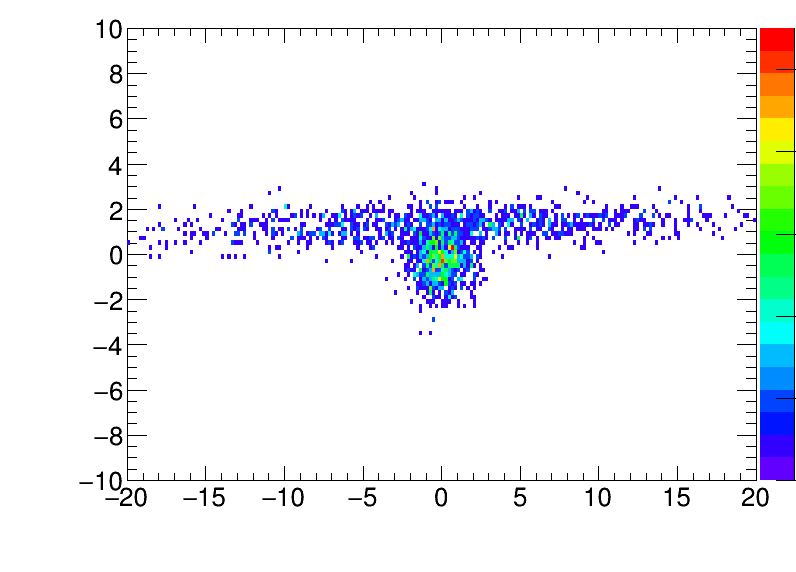

In [14]:
myc = R.TCanvas("c", "c", 800, 600)
myc.SetFillColor(0)

nbinsx, xmin, xmax = 200, -20, 20
nbinsy, ymin, ymax = 100, -10, 10
hname = "training_sig"
h_s = R.TH2F(hname, hname, nbinsx, xmin, xmax, nbinsy, ymin, ymax)
h_s.SetMarkerColor(2)
hname = "training_bkg"
h_b = R.TH2F(hname, hname, nbinsx, xmin, xmax, nbinsy, ymin, ymax)
h_b.SetMarkerColor(4)

for i in range(len(l_tr_s)):
  [x, y] = l_tr_s[i]
  h_s.Fill(x, y)
for i in range(len(l_tr_b)):
  [x, y] = l_tr_b[i]
  h_b.Fill(x, y)

h_s.Draw()
h_b.Draw("same")

myc.Update()
myc.Draw()
myc.SaveAs("gaus_test_0_doRotation{0}.png".format(doRotation))

h_s.Draw("colz")
h_b.Draw("colz same")

myc.Draw()
myc.SaveAs("gaus_test_1_doRotation{0}.png".format(doRotation))

Overlay the multi-Gaussian PDF

Helper function for 2D Gaussian

In [15]:
def gaus_2d(x, par):

  if len(x)<2 or len(par)<3: 
    print("[gaus_2d]: requirs 2D data, and 3 parameters")
    return 0

  # 2D Gaussian
  nd = 2
  # Mean
  mean = [par[0], par[1]]
  # Covariance matrix 
  cov = R.TMatrixD(nd, nd)
  ipar = 0
  for j in range(nd):
    for k in range(nd):
      R.TMatrixDRow(cov, j)[k] = par[ipar + 2]
      ipar += 1

  # Correlation
  sx = R.TMatrixDRow(cov, 0)[0]
  sy = R.TMatrixDRow(cov, 1)[1]

  sxy = R.TMatrixDRow(cov, 0)[1]
  rho = sxy / sqrt(sx*sy)

  if fabs(rho)==1:
    print("[gaus_2d]: error rho = ", rho)
    return 1

  # Build the multi-Gaussian
  m_x = R.TMatrixD(nd, 1)
  for i in range(nd):
    R.TMatrixDRow(m_x, i)[0] = x[i] - mean[i]

  m_x_t = R.TMatrixD(m_x)
  m_x_t.T()

  cov_d = 0
  icov = R.TMatrixD(cov)
  icov.Invert(cov_d)
  cov_d = cov.Determinant()
  icov_d = icov.Determinant()

  r = 0
  # r = (m_x_t * icov) * m_x
  for i in range(nd):
    for j in range(nd):
      r += R.TMatrixDRow(m_x_t, 0)[j] * R.TMatrixDRow(icov, i)[j] * R.TMatrixDRow(m_x, i)[0]

  # y = 1./(2*pi* sx * sy * sqrt(1. - pow(rho, 2))) * exp( - 1./(2*(1. - pow(rho, 2))) * ( pow(x[0]/sx, 2) + pow(x[1]/sy, 2) - 2*rho*x[0]*x[1]/(sx*sy) ) )
  y = 1./(2*pi * sqrt(cov_d)) * exp( -0.5* r ) 

  return y

Signal 

Info in <TCanvas::Print>: png file gaus_test_2_doRotation1.png has been created


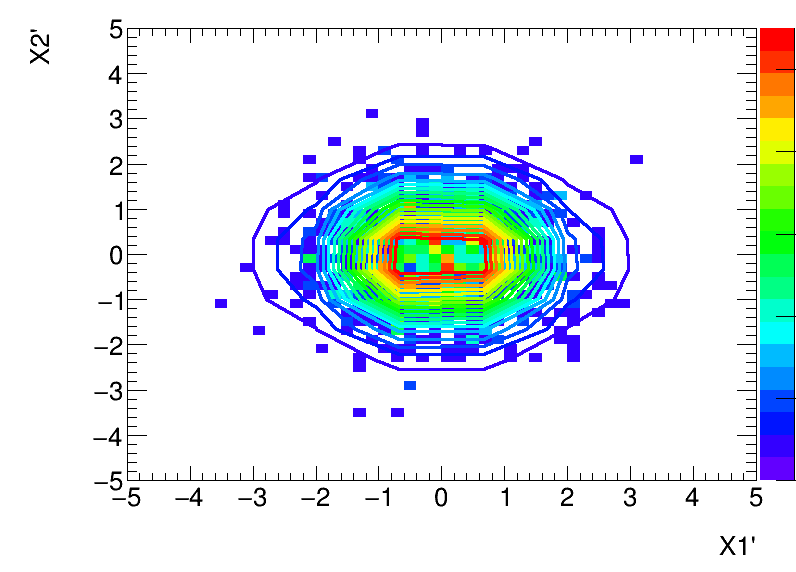

In [16]:
npar = 6 # mean: 2; cov: 2*2
g_s = R.TF2("gaus_s", gaus_2d, xmin, xmax, ymin, ymax, npar)
g_s.SetParameter(0, l_tr_s_mean[0])
g_s.SetParameter(1, l_tr_s_mean[1])
g_s.SetParameter(2, R.TMatrixDRow(m_tr_s_cov, 0)[0])
g_s.SetParameter(3, R.TMatrixDRow(m_tr_s_cov, 0)[1])
g_s.SetParameter(4, R.TMatrixDRow(m_tr_s_cov, 1)[0])
g_s.SetParameter(5, R.TMatrixDRow(m_tr_s_cov, 1)[1])

myc.Clear()
h_s.GetXaxis().SetRangeUser(-5, 5)
h_s.GetYaxis().SetRangeUser(-5, 5)
if doRotation:
  h_s.GetXaxis().SetTitle("X1'")
  h_s.GetYaxis().SetTitle("X2'")
else:
  h_s.GetXaxis().SetTitle("X1")
  h_s.GetYaxis().SetTitle("X2")

h_s.Draw("colz")
g_s.Draw("cont1 same")

myc.Draw()
myc.SaveAs("gaus_test_2_doRotation{0}.png".format(doRotation))

Background

Info in <TCanvas::Print>: png file gaus_test_3_doRotation1.png has been created


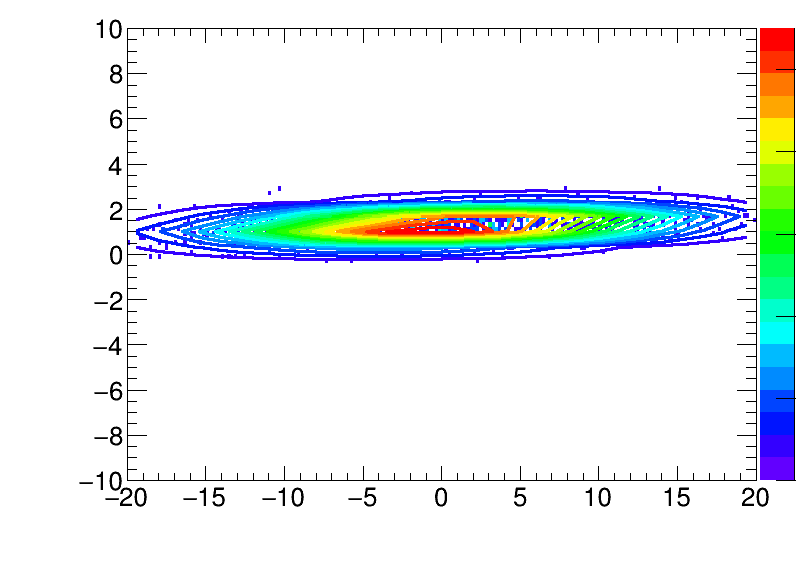

In [17]:
npar = 6 # mean: 2; cov: 2*2
g_b = R.TF2("gaus_b", gaus_2d, xmin, xmax, ymin, ymax, npar)
g_b.SetParameter(0, l_tr_b_mean[0])
g_b.SetParameter(1, l_tr_b_mean[1])
g_b.SetParameter(2, R.TMatrixDRow(m_tr_b_cov, 0)[0])
g_b.SetParameter(3, R.TMatrixDRow(m_tr_b_cov, 0)[1])
g_b.SetParameter(4, R.TMatrixDRow(m_tr_b_cov, 1)[0])
g_b.SetParameter(5, R.TMatrixDRow(m_tr_b_cov, 1)[1])

myc.Clear()
h_b.Draw("colz")
g_b.Draw("cont1 same")

myc.Draw()
myc.SaveAs("gaus_test_3_doRotation{0}.png".format(doRotation))

Gaussian classifier
=====================

In [18]:
def r_gaus(l_x=[], mean_s=[], cov_s=None, mean_b=[], cov_b=None, l_pi=[]):
  
  nd = len(l_x)
 
  # Signal 
  m_x_s = R.TMatrixD(nd, 1)
  for i in range(nd):
    R.TMatrixDRow(m_x_s, i)[0] = l_x[i] - mean_s[i]

  m_x_s_t = R.TMatrixD(m_x_s)
  m_x_s_t.T()

  cov_s_d = 0
  icov_s = R.TMatrixD(cov_s)
  icov_s.Invert(cov_s_d)
  cov_s_d = cov_s.Determinant()
  icov_s_d = icov_s.Determinant()

  r_s = 0
  # r_s = (m_x_s_t * icov_s) * m_x_s
  for i in range(nd):
    for j in range(nd):
      r_s += R.TMatrixDRow(m_x_s_t, 0)[j] * R.TMatrixDRow(icov_s, i)[j] * R.TMatrixDRow(m_x_s, i)[0]
  
  # Background
  m_x_b = R.TMatrixD(nd, 1)
  for i in range(nd):
    R.TMatrixDRow(m_x_b, i)[0] = l_x[i] - mean_b[i]
  
  m_x_b_t = R.TMatrixD(m_x_b)
  m_x_b_t.T()

  cov_b_d = 0
  icov_b = R.TMatrixD(cov_b)
  icov_b.Invert(cov_b_d)
  cov_b_d = cov_b.Determinant()
  icov_b_d = icov_b.Determinant()

  r_b = 0
  # r_b = m_x_b_t * icov_b * m_x_b
  for i in range(nd):
    for j in range(nd):
      r_b += R.TMatrixDRow(m_x_b_t, 0)[j] * R.TMatrixDRow(icov_b, i)[j] * R.TMatrixDRow(m_x_b, i)[0]

  # Classification
  y = 0
 
  if r_s < r_b + 2*log(l_pi[0]/l_pi[1]) + log(cov_b_d/cov_s_d): y = 1.

  return y

Test
=====================

In [19]:
print("\nTest classification: input signal ")
ntest_s = len(l_test_s)
ntest_s_good = 0


Test classification: input signal 


Assuming equal signal and bkg

In [20]:
l_pi = [0.5]*2
for i in range(ntest_s):
  y = r_gaus(l_test_s[i], l_tr_s_mean, m_tr_s_cov, l_tr_b_mean, m_tr_b_cov, l_pi)
  if y == 1: ntest_s_good += 1

rate_s = ntest_s_good/ float(ntest_s)
print("Accuracy: {0} / {1} = {2}".format(ntest_s_good, ntest_s, rate_s))

print("\nTest classification: input bkg ")
ntest_b = len(l_test_b)
ntest_b_good = 0
for i in range(ntest_b):
  y = r_gaus(l_test_b[i], l_tr_s_mean, m_tr_s_cov, l_tr_b_mean, m_tr_b_cov, l_pi)
  if y == 1: ntest_b_good += 1

rate_b = ntest_b_good/ float(ntest_b)
print("Accuracy: {0} / {1} = {2}".format(ntest_b_good, ntest_b, rate_b))

Accuracy: 947378 / 999000 = 0.9483263263263263

Test classification: input bkg 
Accuracy: 121688 / 999000 = 0.12180980980980981


Application
=====================

In [21]:
fname_d = "real_data.root"
if not os.path.isfile(fname_d):
    call(['curl', '-L', '-O', 'http://yliu.web.cern.ch/yliu/HLZ_logs/real_data.root'])
tfin_d = R.TFile.Open(fname_d, "READ")
tr_d = tfin_d.Get("data;2")

[l_tr_d, l_test_d] = read_tr(tr_d)
l_test_d.extend(l_tr_d)

hname = "data"
h_d = R.TH2F(hname, hname, nbinsx, xmin, xmax, nbinsy, ymin, ymax)
h_d.SetMarkerColor(1)
hname = "data_sig"
h_ds = R.TH2F(hname, hname, nbinsx, xmin, xmax, nbinsy, ymin, ymax)
h_ds.SetMarkerColor(2)
hname = "data_bkg"
h_db = R.TH2F(hname, hname, nbinsx, xmin, xmax, nbinsy, ymin, ymax)
h_db.SetMarkerColor(4)

print("\nTest classification: real data ")
ntest_d = len(l_test_d)
ntest_d_good = 0
for i in range(ntest_d):
  r = r_gaus(l_test_d[i], l_tr_s_mean, m_tr_s_cov, l_tr_b_mean, m_tr_b_cov, l_pi)

  [x, y] = l_test_d[i]

  if r == 1:
    ntest_d_good += 1
    h_ds.Fill(x, y)
  else:
    h_db.Fill(x, y)
  h_d.Fill(x, y)

rate_d = ntest_d_good/ float(ntest_d)
print("Estimated signal events: {0} / {1} = {2}".format(ntest_d_good, ntest_d, rate_d))

[read_tr] data, Number of events: 9100
 Events processed:  0
 Events processed:  910
 Events processed:  1820
 Events processed:  2730
 Events processed:  3640
 Events processed:  4550
 Events processed:  5460
 Events processed:  6370
 Events processed:  7280
 Events processed:  8190

Test classification: real data 
Estimated signal events: 1197 / 9100 = 0.13153846153846155


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   171  100   171    0     0    134      0  0:00:01  0:00:01 --:--:--   134
100  143k  100  143k    0     0  45214      0  0:00:03  0:00:03 --:--:--  129k
Warning in <TFile::Append>: Replacing existing TH1: data (Potential memory leak).


Plot real data, training signal and bkg

Info in <TCanvas::Print>: png file gaus_test_4_doRotation1.png has been created


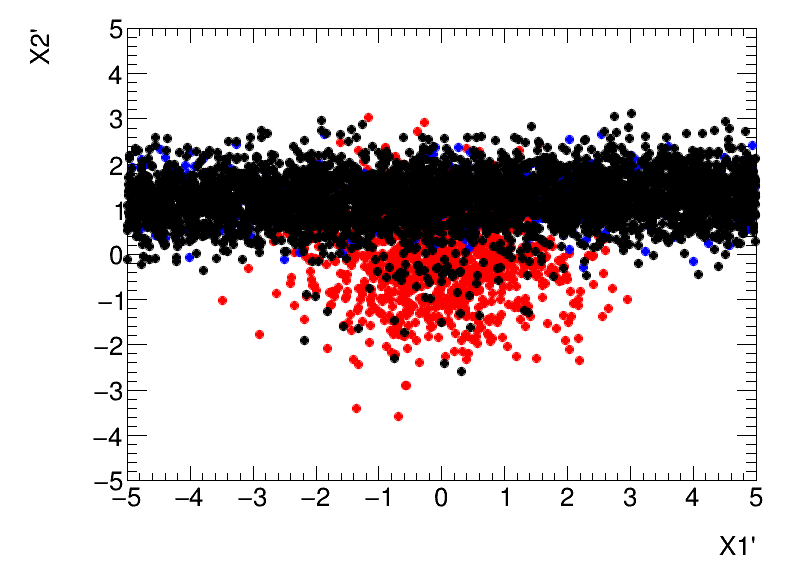

In [22]:
h_s.Draw()
h_b.Draw("same")
h_d.Draw("same")

myc.Draw()
myc.SaveAs("gaus_test_4_doRotation{0}.png".format(doRotation))

Apply the classifier to data

Info in <TCanvas::Print>: png file gaus_test_5_doRotation1.png has been created


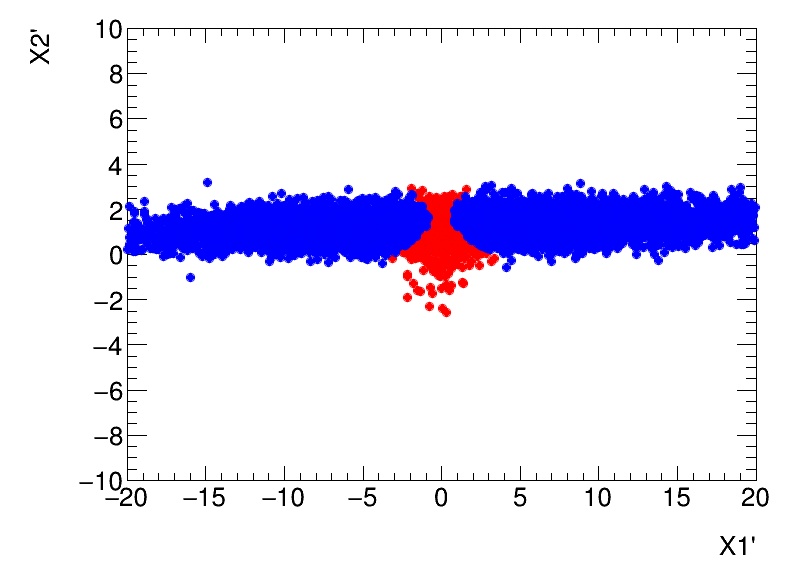

In [23]:
if doRotation:
  h_ds.GetXaxis().SetTitle("X1'")
  h_ds.GetYaxis().SetTitle("X2'")
else:
  h_ds.GetXaxis().SetTitle("X1")
  h_ds.GetYaxis().SetTitle("X2")

h_ds.Draw()
h_db.Draw("same")

myc.Draw()
myc.SaveAs("gaus_test_5_doRotation{0}.png".format(doRotation))

Test a different signal/bkg ratio

In [24]:
h_ds.Clear()
h_db.Clear()
l_pi = [0.1, 0.9]
ntest_d = len(l_test_d)
ntest_d_good = 0
for i in range(ntest_d):
  r = r_gaus(l_test_d[i], l_tr_s_mean, m_tr_s_cov, l_tr_b_mean, m_tr_b_cov, l_pi)

  [x, y] = l_test_d[i]

  if r == 1:
    ntest_d_good += 1
    h_ds.Fill(x, y)
  else:
    h_db.Fill(x, y)

rate_d = ntest_d_good/ float(ntest_d)
print("Estimated signal events: {0} / {1} = {2}".format(ntest_d_good, ntest_d, rate_d))

Estimated signal events: 149 / 9100 = 0.016373626373626375


Apply the classifier to data

Info in <TCanvas::Print>: png file gaus_test_6_doRotation1.png has been created


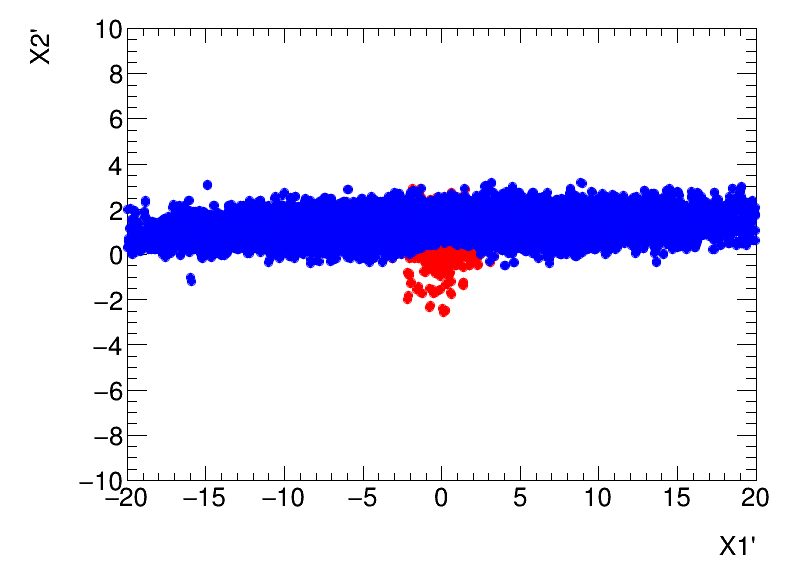

In [25]:
if doRotation:
  h_ds.GetXaxis().SetTitle("X1'")
  h_ds.GetYaxis().SetTitle("X2'")
else:
  h_ds.GetXaxis().SetTitle("X1")
  h_ds.GetYaxis().SetTitle("X2")

h_ds.Draw()
h_db.Draw("same")

myc.Draw()
myc.SaveAs("gaus_test_6_doRotation{0}.png".format(doRotation))

Draw all canvases 

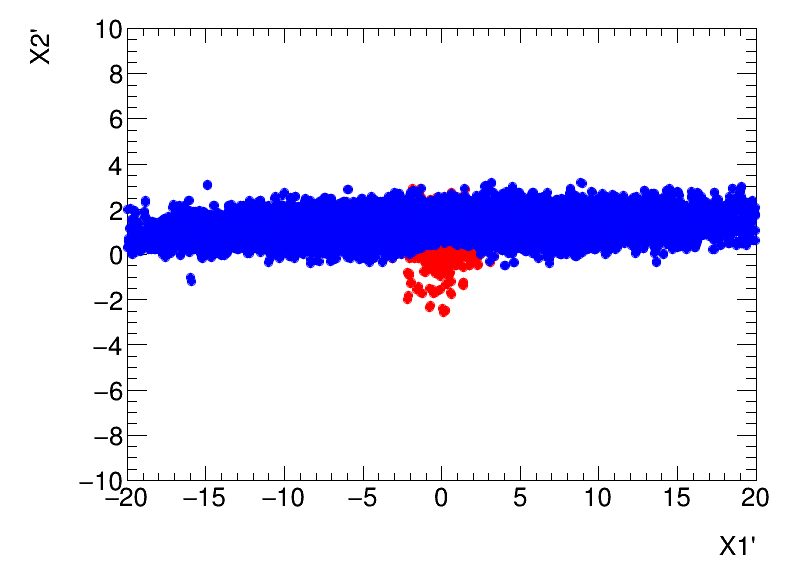

In [26]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()